In [1]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
#%matplotlib inline
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

In [2]:
def readImage(fn,jpeg=False,ext=1):
    """Reads FITS and jpeg images so that x,y indices refer to the same pixels
    regardless of image format. x,y and fits correspond so the jpeg is rotated and flipped 
    to align with fits
    
    Args:
        fn: image filename
        jpeg: bool, is is a jpeg?
    """
    if jpeg:
        img= skimage.io.imread(fn)
        for i in range(3):
            img[:,:,i]= np.rot90(img[:,:,i].T,1)
    else:
        img= fitsio.FITS(fn)[ext].read()
    return img

def sliceImage(img,
               xslice=slice(None,None),yslice=slice(None,None)):
    """Not sure why, but simcat.x[xslice],simcat.y[yslice]
    corresponds to img[yslice,xslice], eg inverted for the image"""
    return img[yslice,xslice,...]

class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        elif qs is None:
            minmax=[None,None]
            cmap='gray'
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')
        
    def circles(self,xs,ys,ax,
                img_shape=None,
                xslice=None,yslice=None,
                r_pixels=5./0.262,color='y'):
        """
        xs,ys: x,y positions of sources in pixels, e.g. tractor.bx or simcat.x
        img_shape: needed when xslice or yslice is None
        xlice,yslice: slice() objects into the image array
        r_pixels: radius circles in pixels
        """
        if (xslice is None) | (yslice is None):
            assert(not img_shape is None)
        if xslice is None:
            xslice= slice(0,img_shape[0])
        if yslice is None:
            yslice= slice(0,img_shape[1])
        keep= self.justInSlice(xs,ys,xslice,yslice)
        xpos,ypos= xs[keep]-xslice.start,ys[keep]-yslice.start
        
        from matplotlib.patches import Circle,Wedge
        from matplotlib.collections import PatchCollection
        dr= r_pixels/ 20 
        patches=[Wedge((x, y), r_pixels + dr, 0, 360,dr)
                 for x,y in zip(xpos, ypos) ]
        coll = PatchCollection(patches, color=color) #,alpha=1)
        ax.add_collection(coll)
        
    def justInSlice(self,x,y,xslice,yslice):
        """Returns bool array of x,y positions in the slice()"""
        return ((x >= xslice.start) & 
               (x <= xslice.stop) &
               (y >= yslice.start) & 
               (y <= yslice.stop))

# testcase_DR_z

In [3]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [4]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


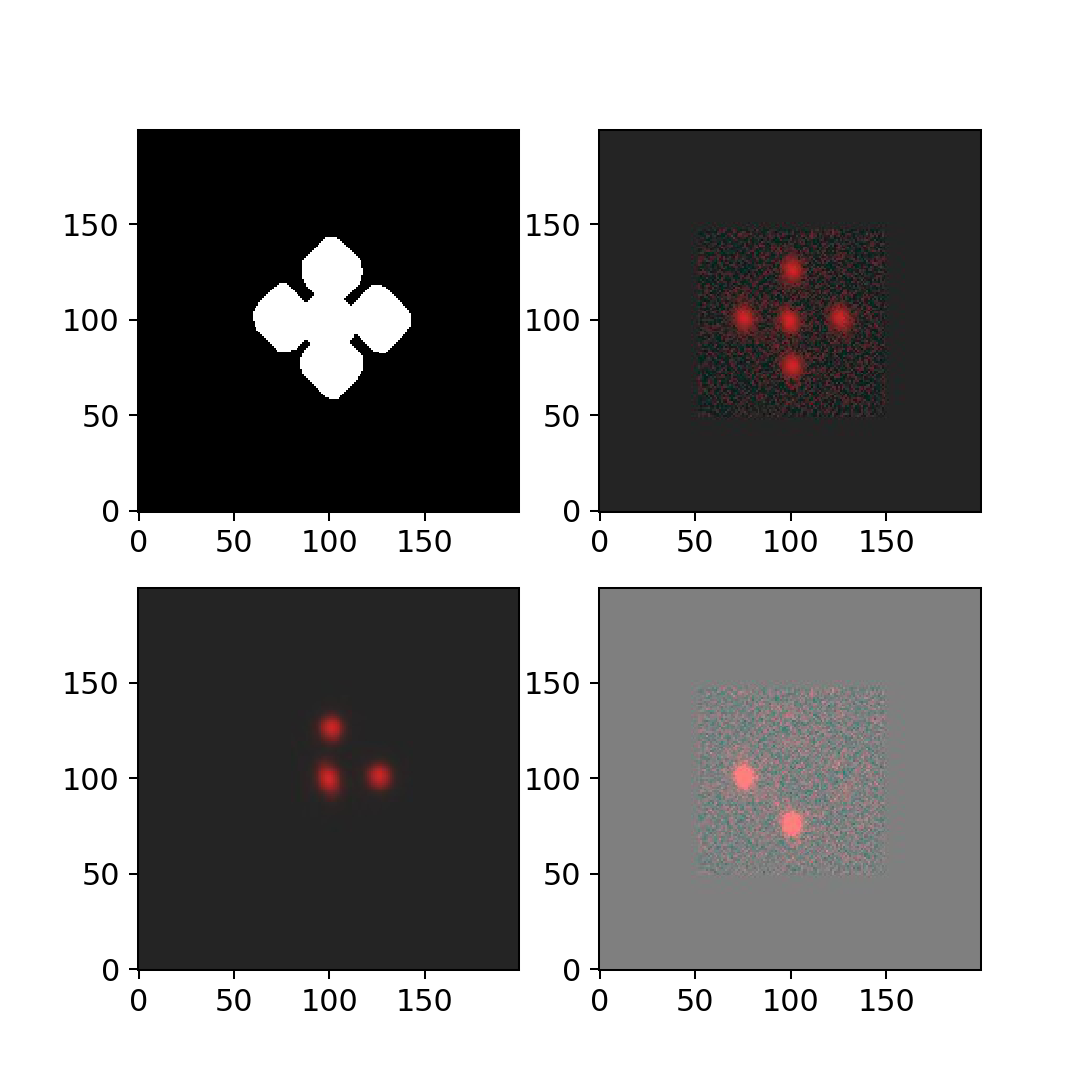

In [5]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_allblobs

In [12]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_allblobs/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [13]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


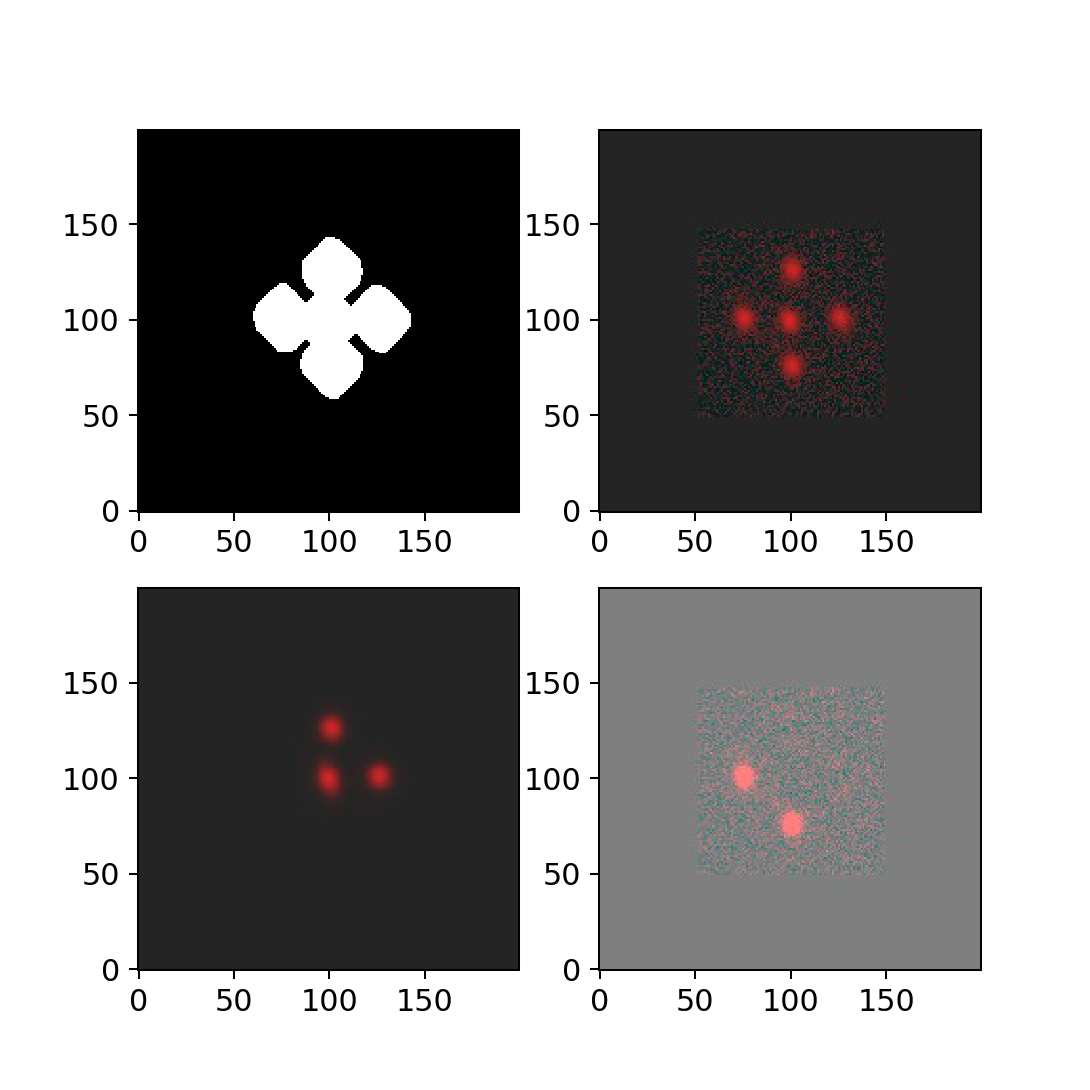

In [14]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_200x200

In [6]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_200x200/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_200x200/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [7]:
len(simcat),len(obitractor),blobs.shape

(4, 4, (200, 200))

<IPython.core.display.Javascript object>


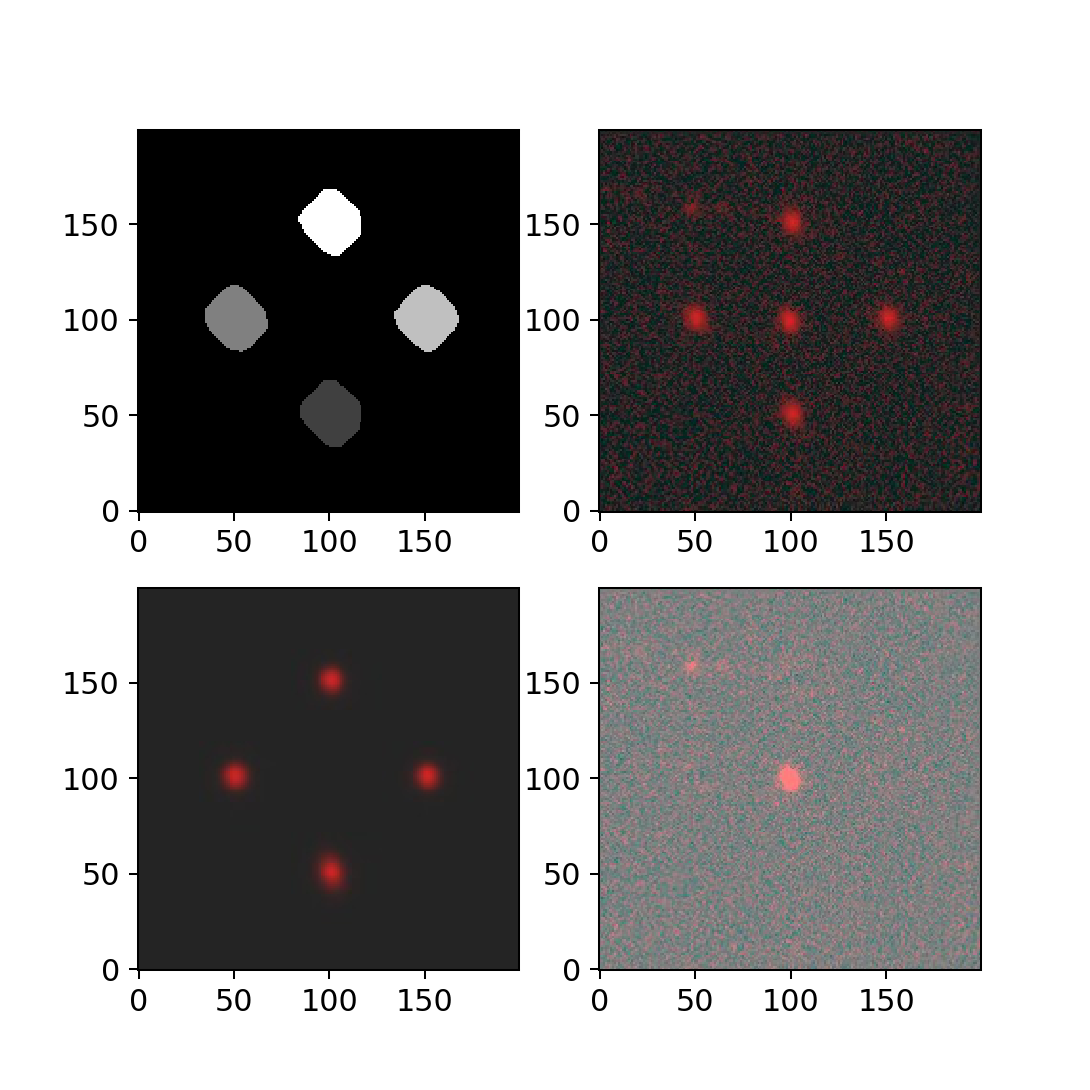

In [8]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_200x200_allblobs

In [9]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_200x200_allblobs/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_200x200_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [10]:
len(simcat),len(obitractor),blobs.shape

(4, 7, (200, 200))

<IPython.core.display.Javascript object>


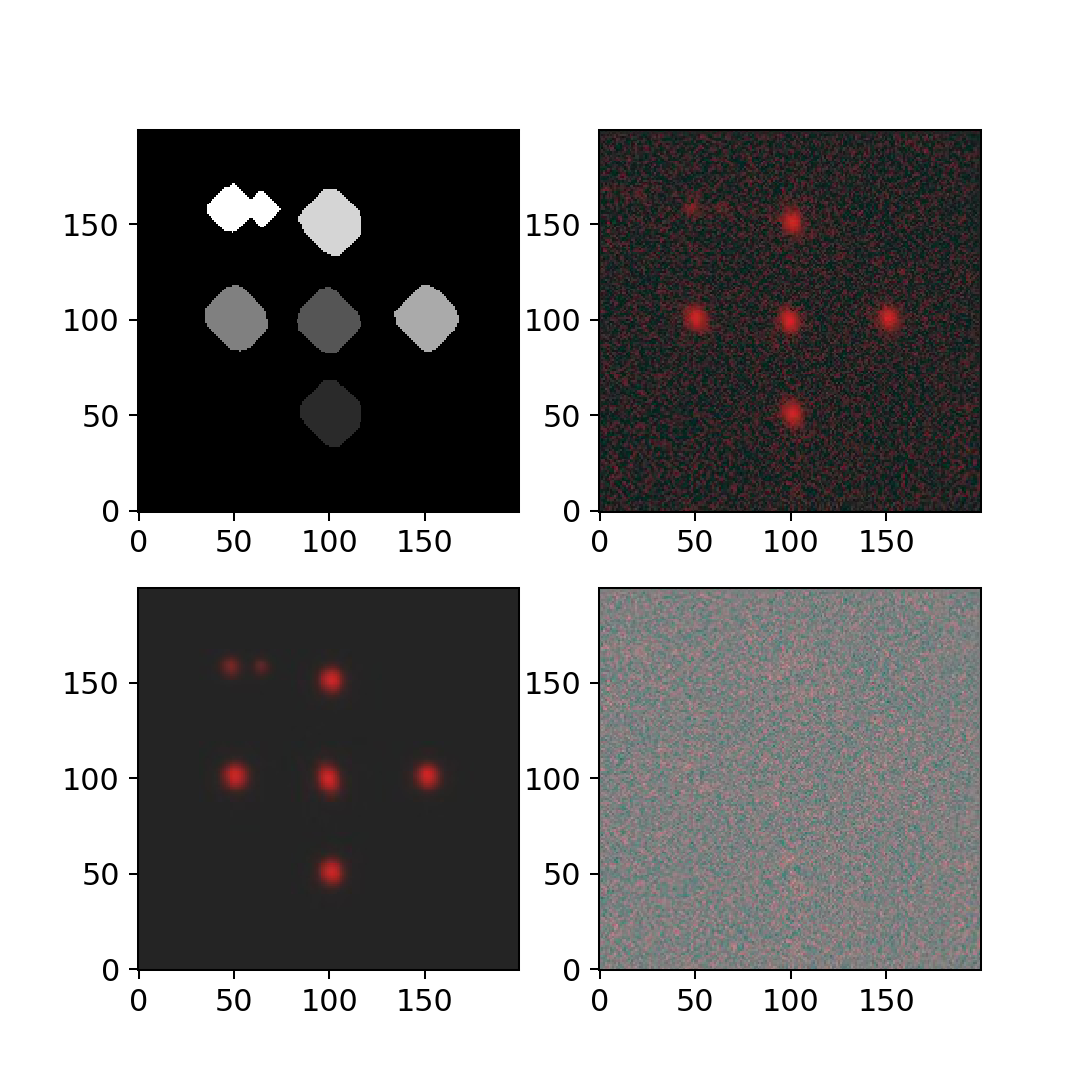

In [11]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

In [6]:
!ls $OUT_DIR/tractor/tractor-


brick-1741p242.sha256sum  tractor-1741p242.fits


# What "zoom" is needed for this testcase?

<IPython.core.display.Javascript object>


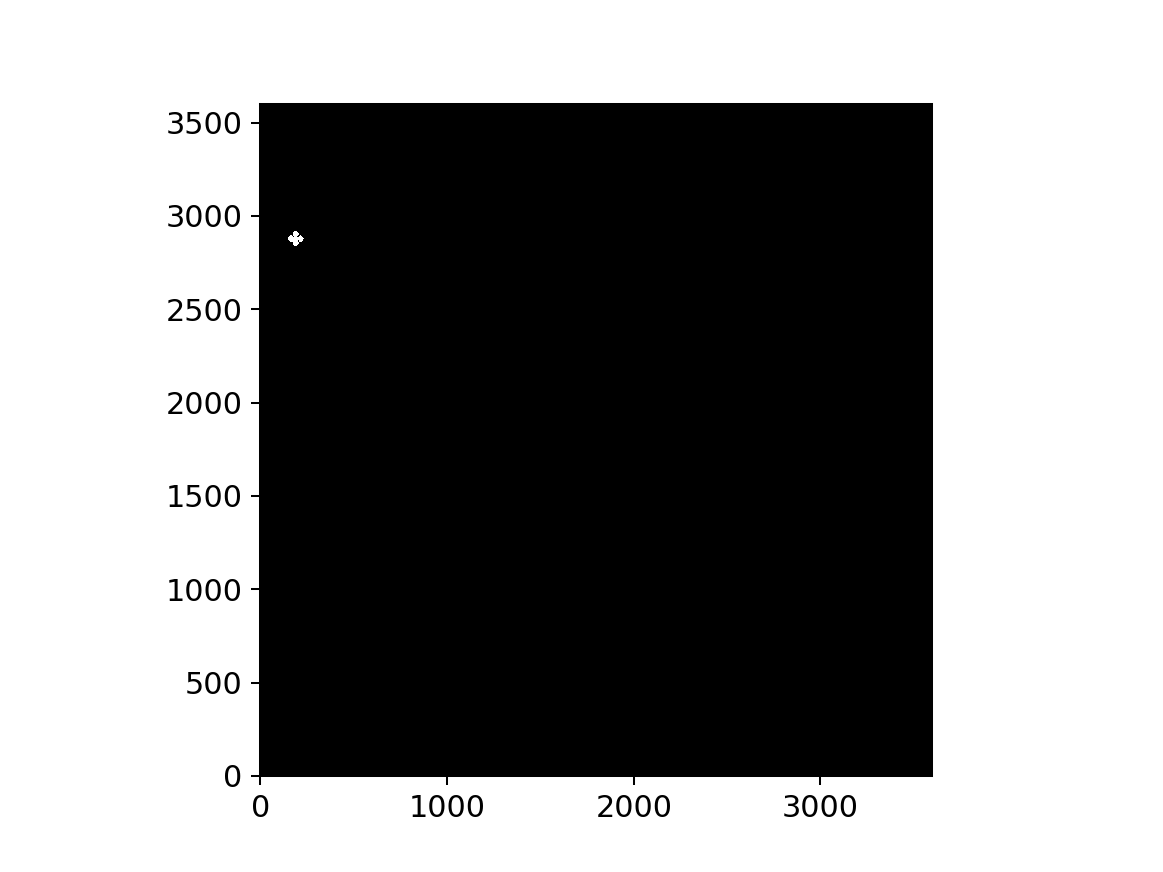

In [22]:
fig,ax=plt.subplots()
plotImage().imshow(blobs,ax,qs=None)

In [27]:
ra=[174.24714700910047, 174.24715333044438, 174.24915898792247, 174.2451413528916]
dec=[24.326224120319477, 24.32988191327332, 24.328050866811363, 24.32805515572893]
np.mean(ra),np.mean(dec)

(174.24715017008975, 24.328053014033273)

In [25]:
os.environ["LEGACY_SURVEY_DIR"]= IN_DIR

from legacypipe.survey import LegacySurveyData, wcs_for_brick
survey = LegacySurveyData()
brickinfo = survey.get_brick_by_name('1741p242')
brickwcs = wcs_for_brick(brickinfo)

In [28]:
brickwcs.radec2pixelxy(174.24715,24.32805)

(True, 190.26994464884524, 2873.6879080454523)

<IPython.core.display.Javascript object>


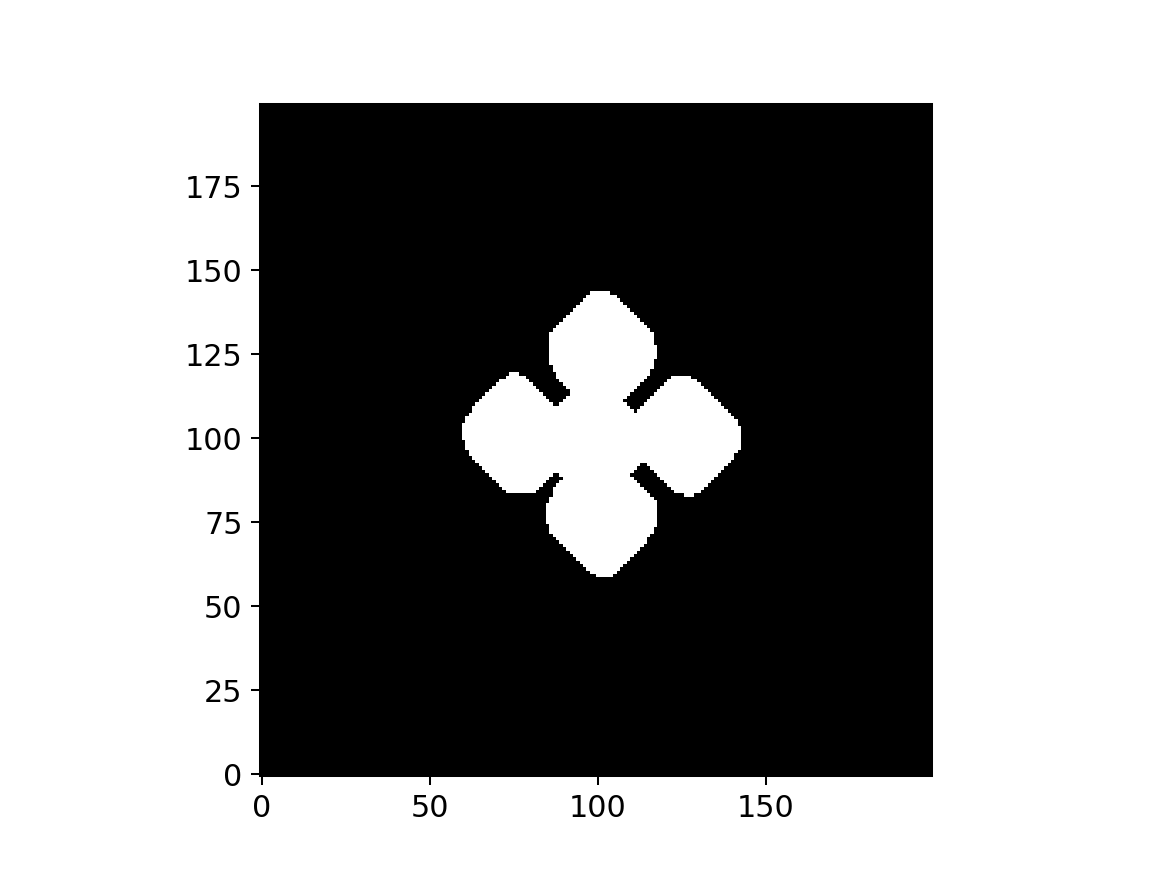

(slice(90, 290, None), slice(2773, 2973, None))


In [38]:
_,x,y= brickwcs.radec2pixelxy(174.2471,24.3262)
x,y= int(x),int(y)+25
hw=100

fig,ax=plt.subplots()
xslc=slice(x-hw,x+hw)
yslc=slice(y-hw,y+hw)
plotImage().imshow(sliceImage(blobs,xslice=xslc,yslice=yslc),
                   ax,qs=None)
print(xslc,yslc)